In [1]:
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def region_plot(left, right, bottom, top, dotwidth=5, linewidth=5, vmax=1e8, padding=0.0, fontsize=80):
    # geography
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # mask
    citymask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
    city_mask = np.fromfile(citymask_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = city_mask[upperindex:lowerindex, leftindex:rightindex]

    # gpw4
    gpw_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
    gpw = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
    gpw_cropped = gpw[upperindex:lowerindex, leftindex:rightindex]
    gpw_masked = np.ma.masked_where(gpw_cropped == 0, gpw_cropped)

    # he 2019
    he_path = f'{h08dir}/camacity/dat/he__data/Global_Urban_Land_2010_upscaled.gl5'
    he = np.fromfile(he_path, dtype='float32').reshape(2160, 4320)
    he_cropped = he[upperindex:lowerindex, leftindex:rightindex]
    he_masked = np.ma.masked_where(he_cropped == 0, he_cropped)

    # city num
    uorder = np.unique(citymask_cropped)
    order = [int(c_tmp) for c_tmp in uorder if c_tmp != 0]

    # ccrs
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(50,50))
    ax = plt.subplot(projection=projection)
    ax.set_extent(img_extent, projection)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=5,edgecolor='#d0cfd4', zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    pop = ax.imshow(gpw_masked, origin='upper', extent = img_extent, transform=projection, 
                    cmap='Oranges', 
                    norm=matplotlib.colors.LogNorm(vmin=1e2, vmax=vmax)
                   )

    for city_num in order:
        city_masked = np.ma.masked_where(citymask_cropped != city_num, citymask_cropped)
        draw_mask_sotowaku_outer(img_extent, city_masked, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding)
        
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 5))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': fontsize, 'color': 'black'}
    gl.ylabel_style = {'size': fontsize, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)

    plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


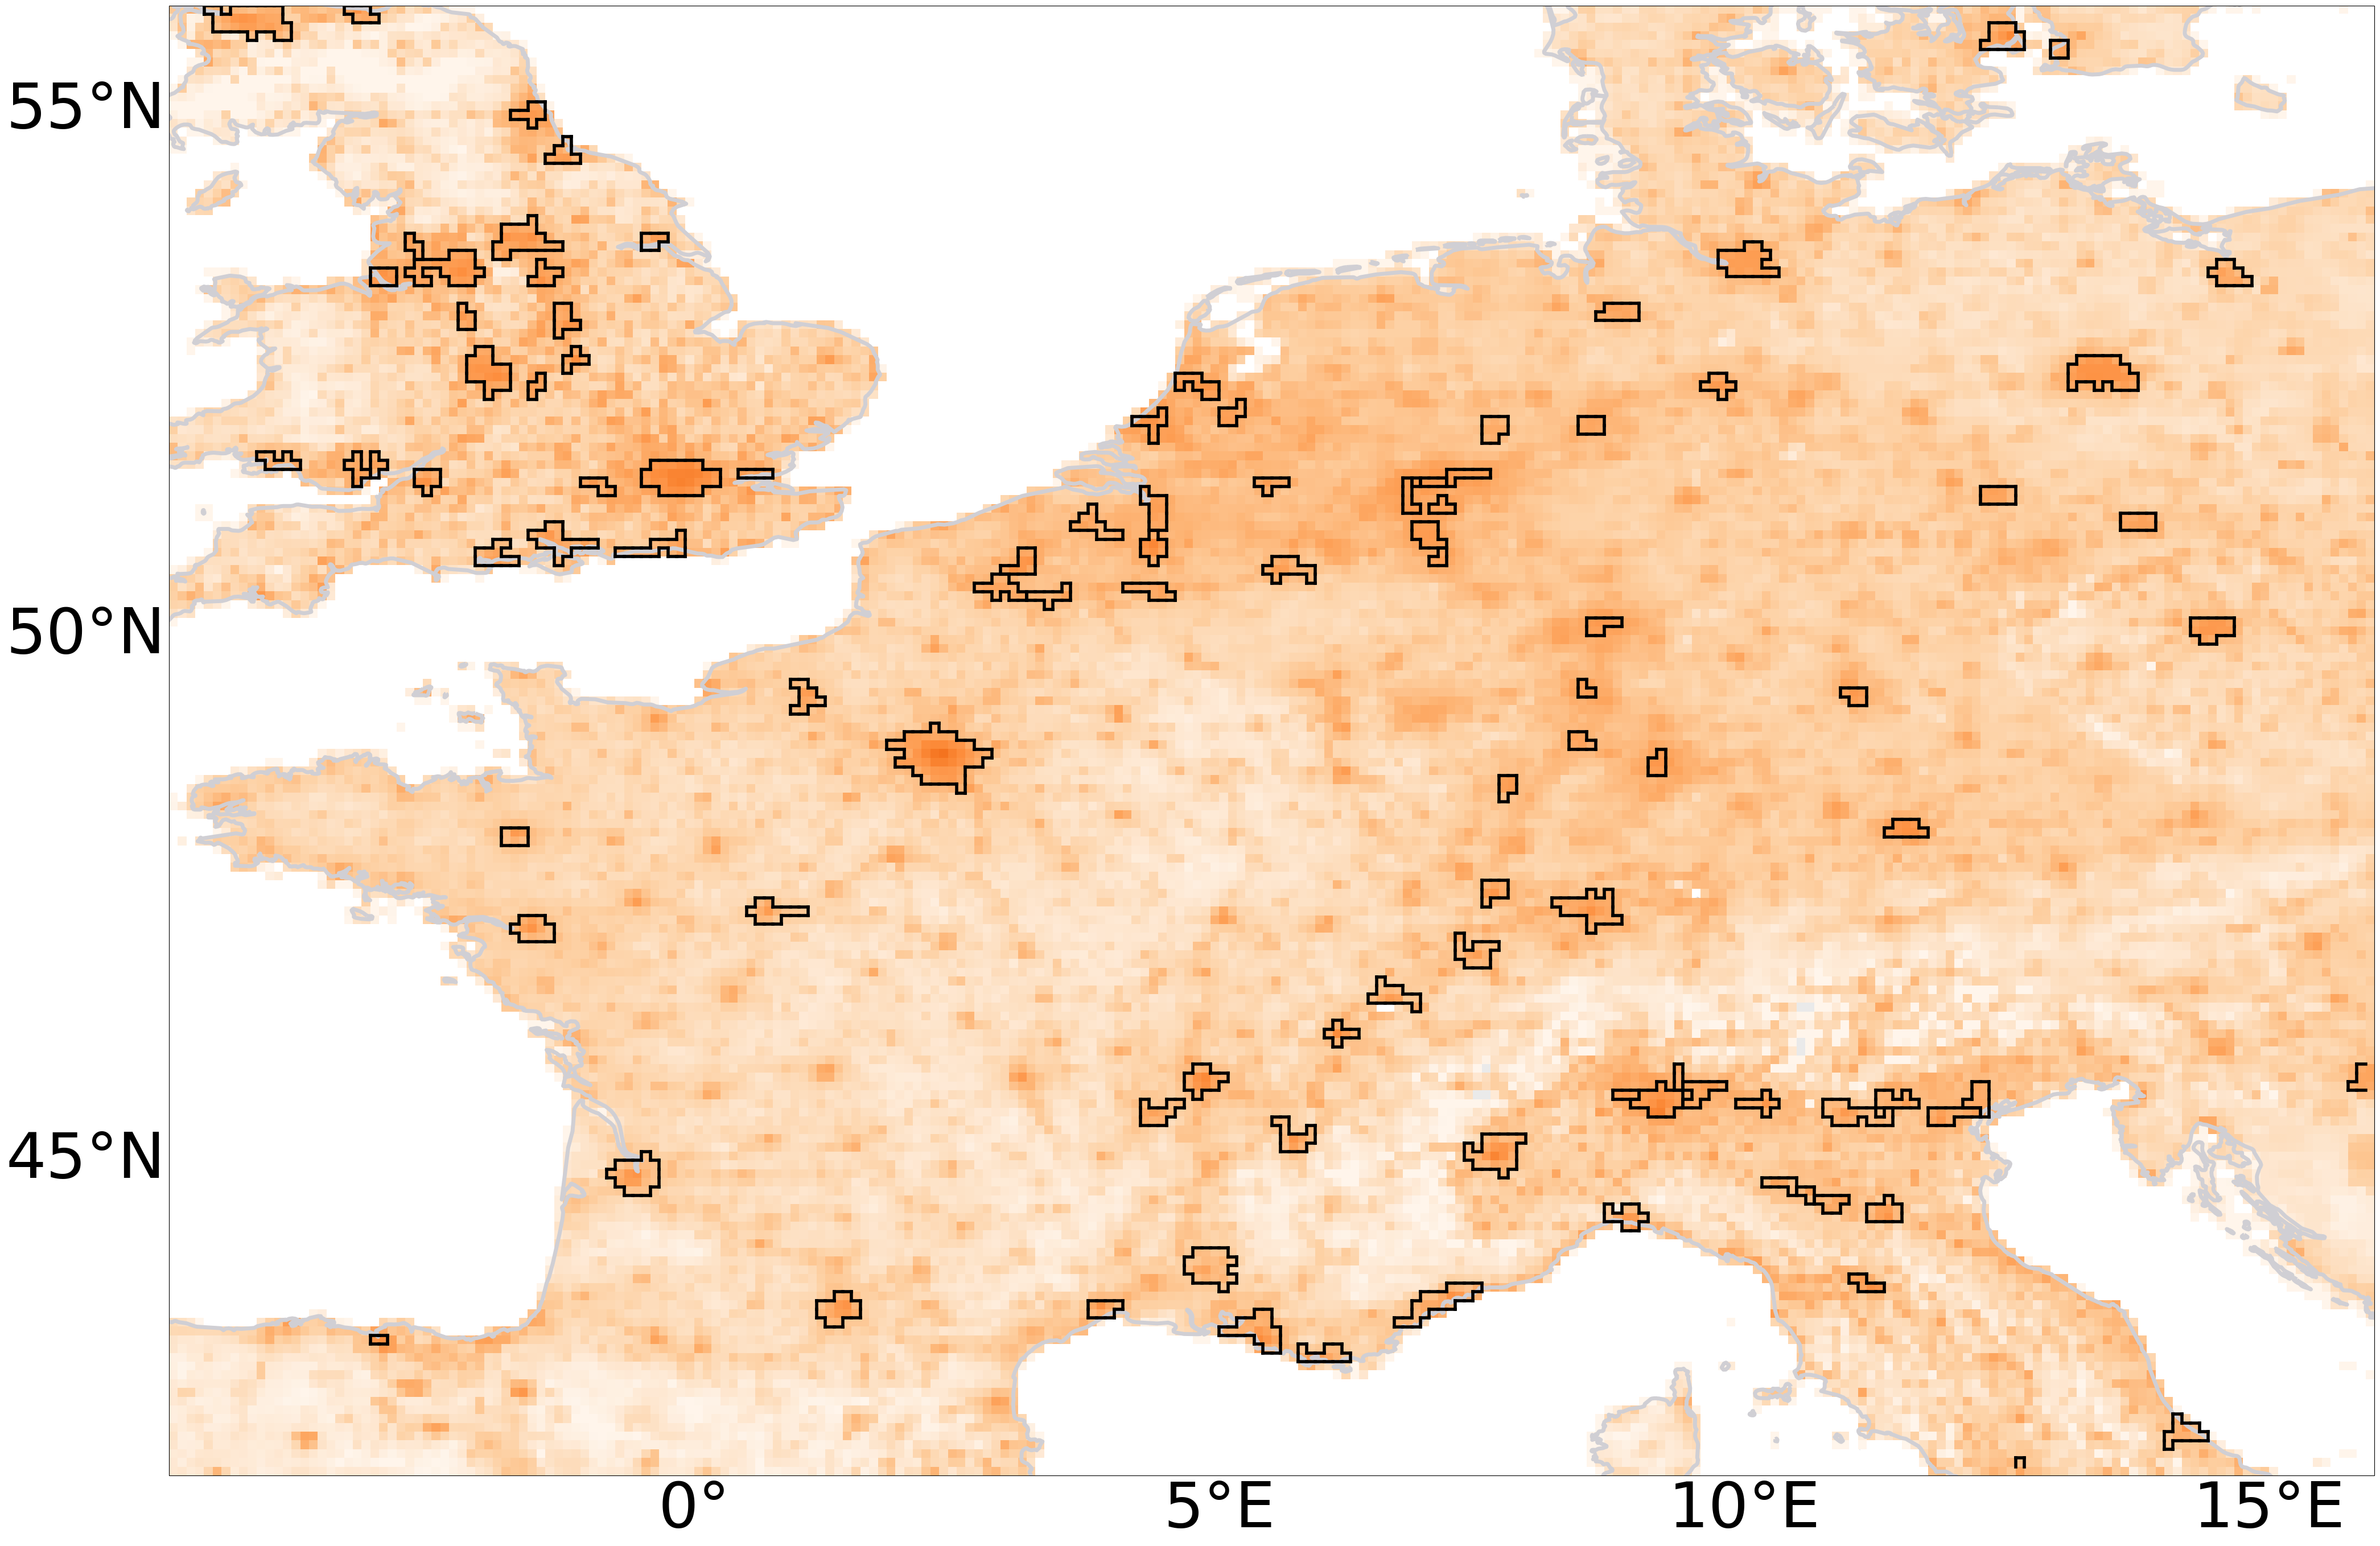

In [2]:
left, right, bottom, top = -5, 16, 42, 56
region_plot(left, right, bottom, top, dotwidth=6, linewidth=4, vmax=1e9)

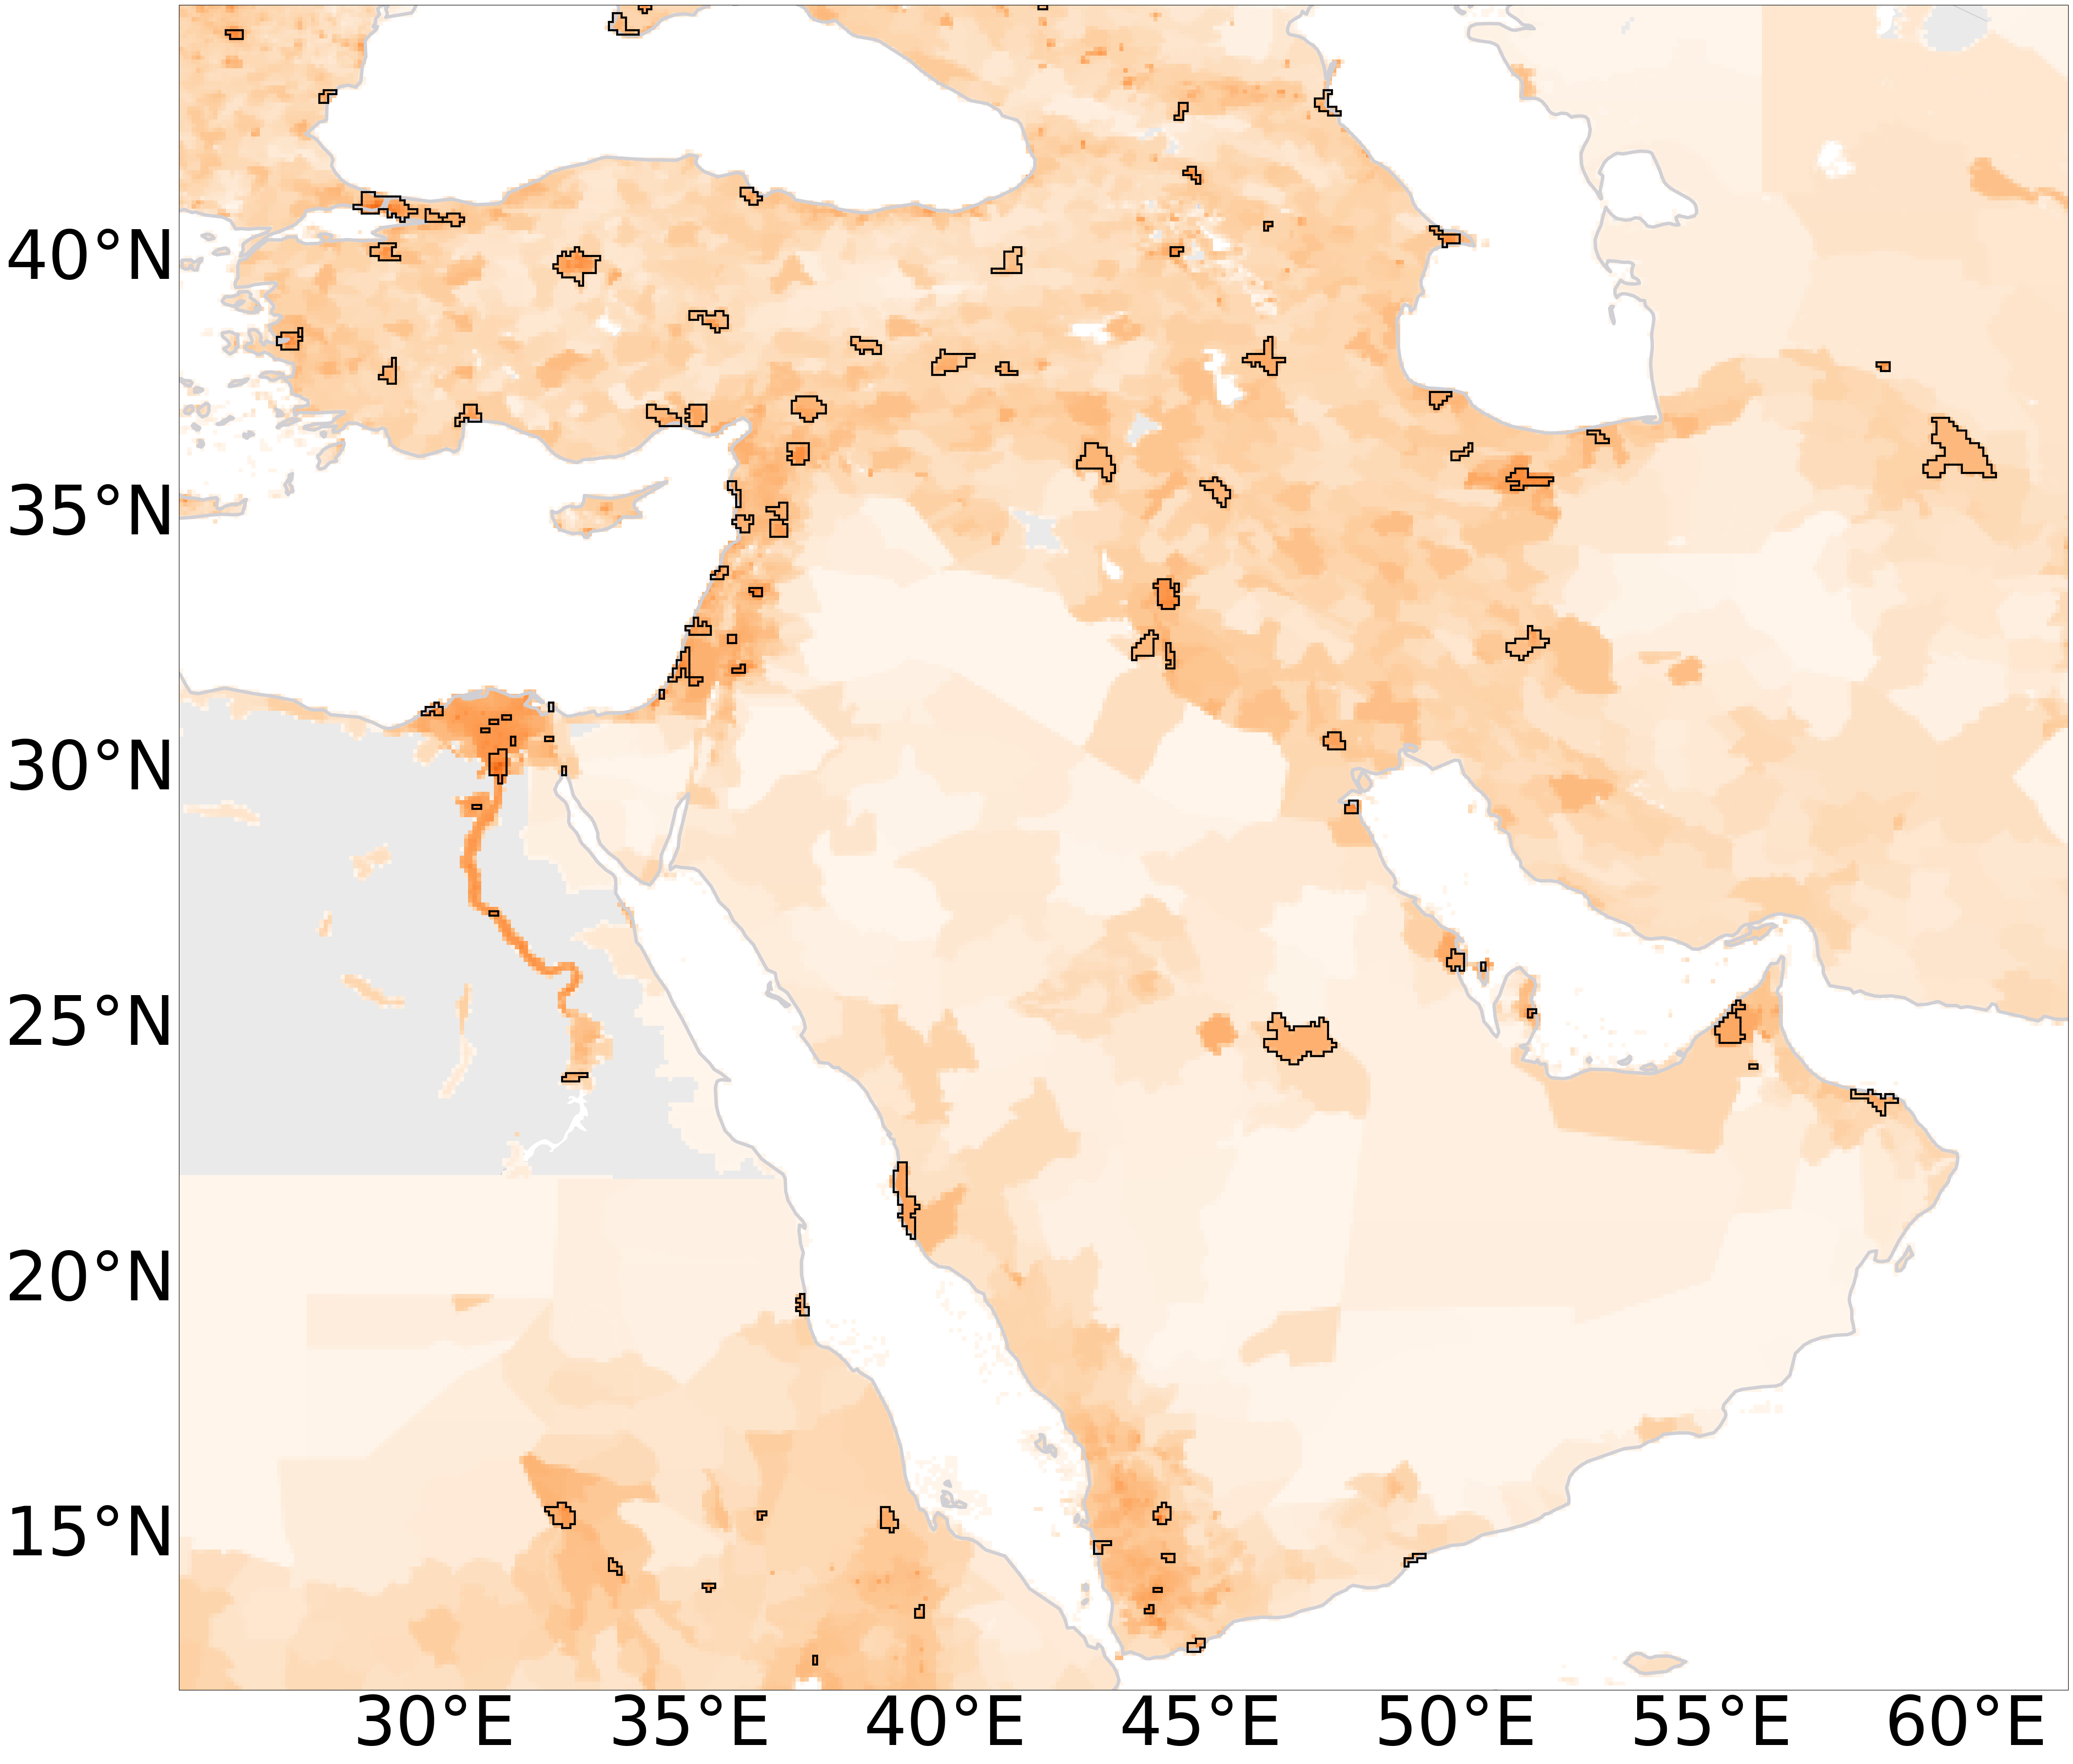

In [3]:
left, right, bottom, top = 25, 62, 12, 45
region_plot(left, right, bottom, top, dotwidth=3, linewidth=3, vmax=1e9, fontsize=100)

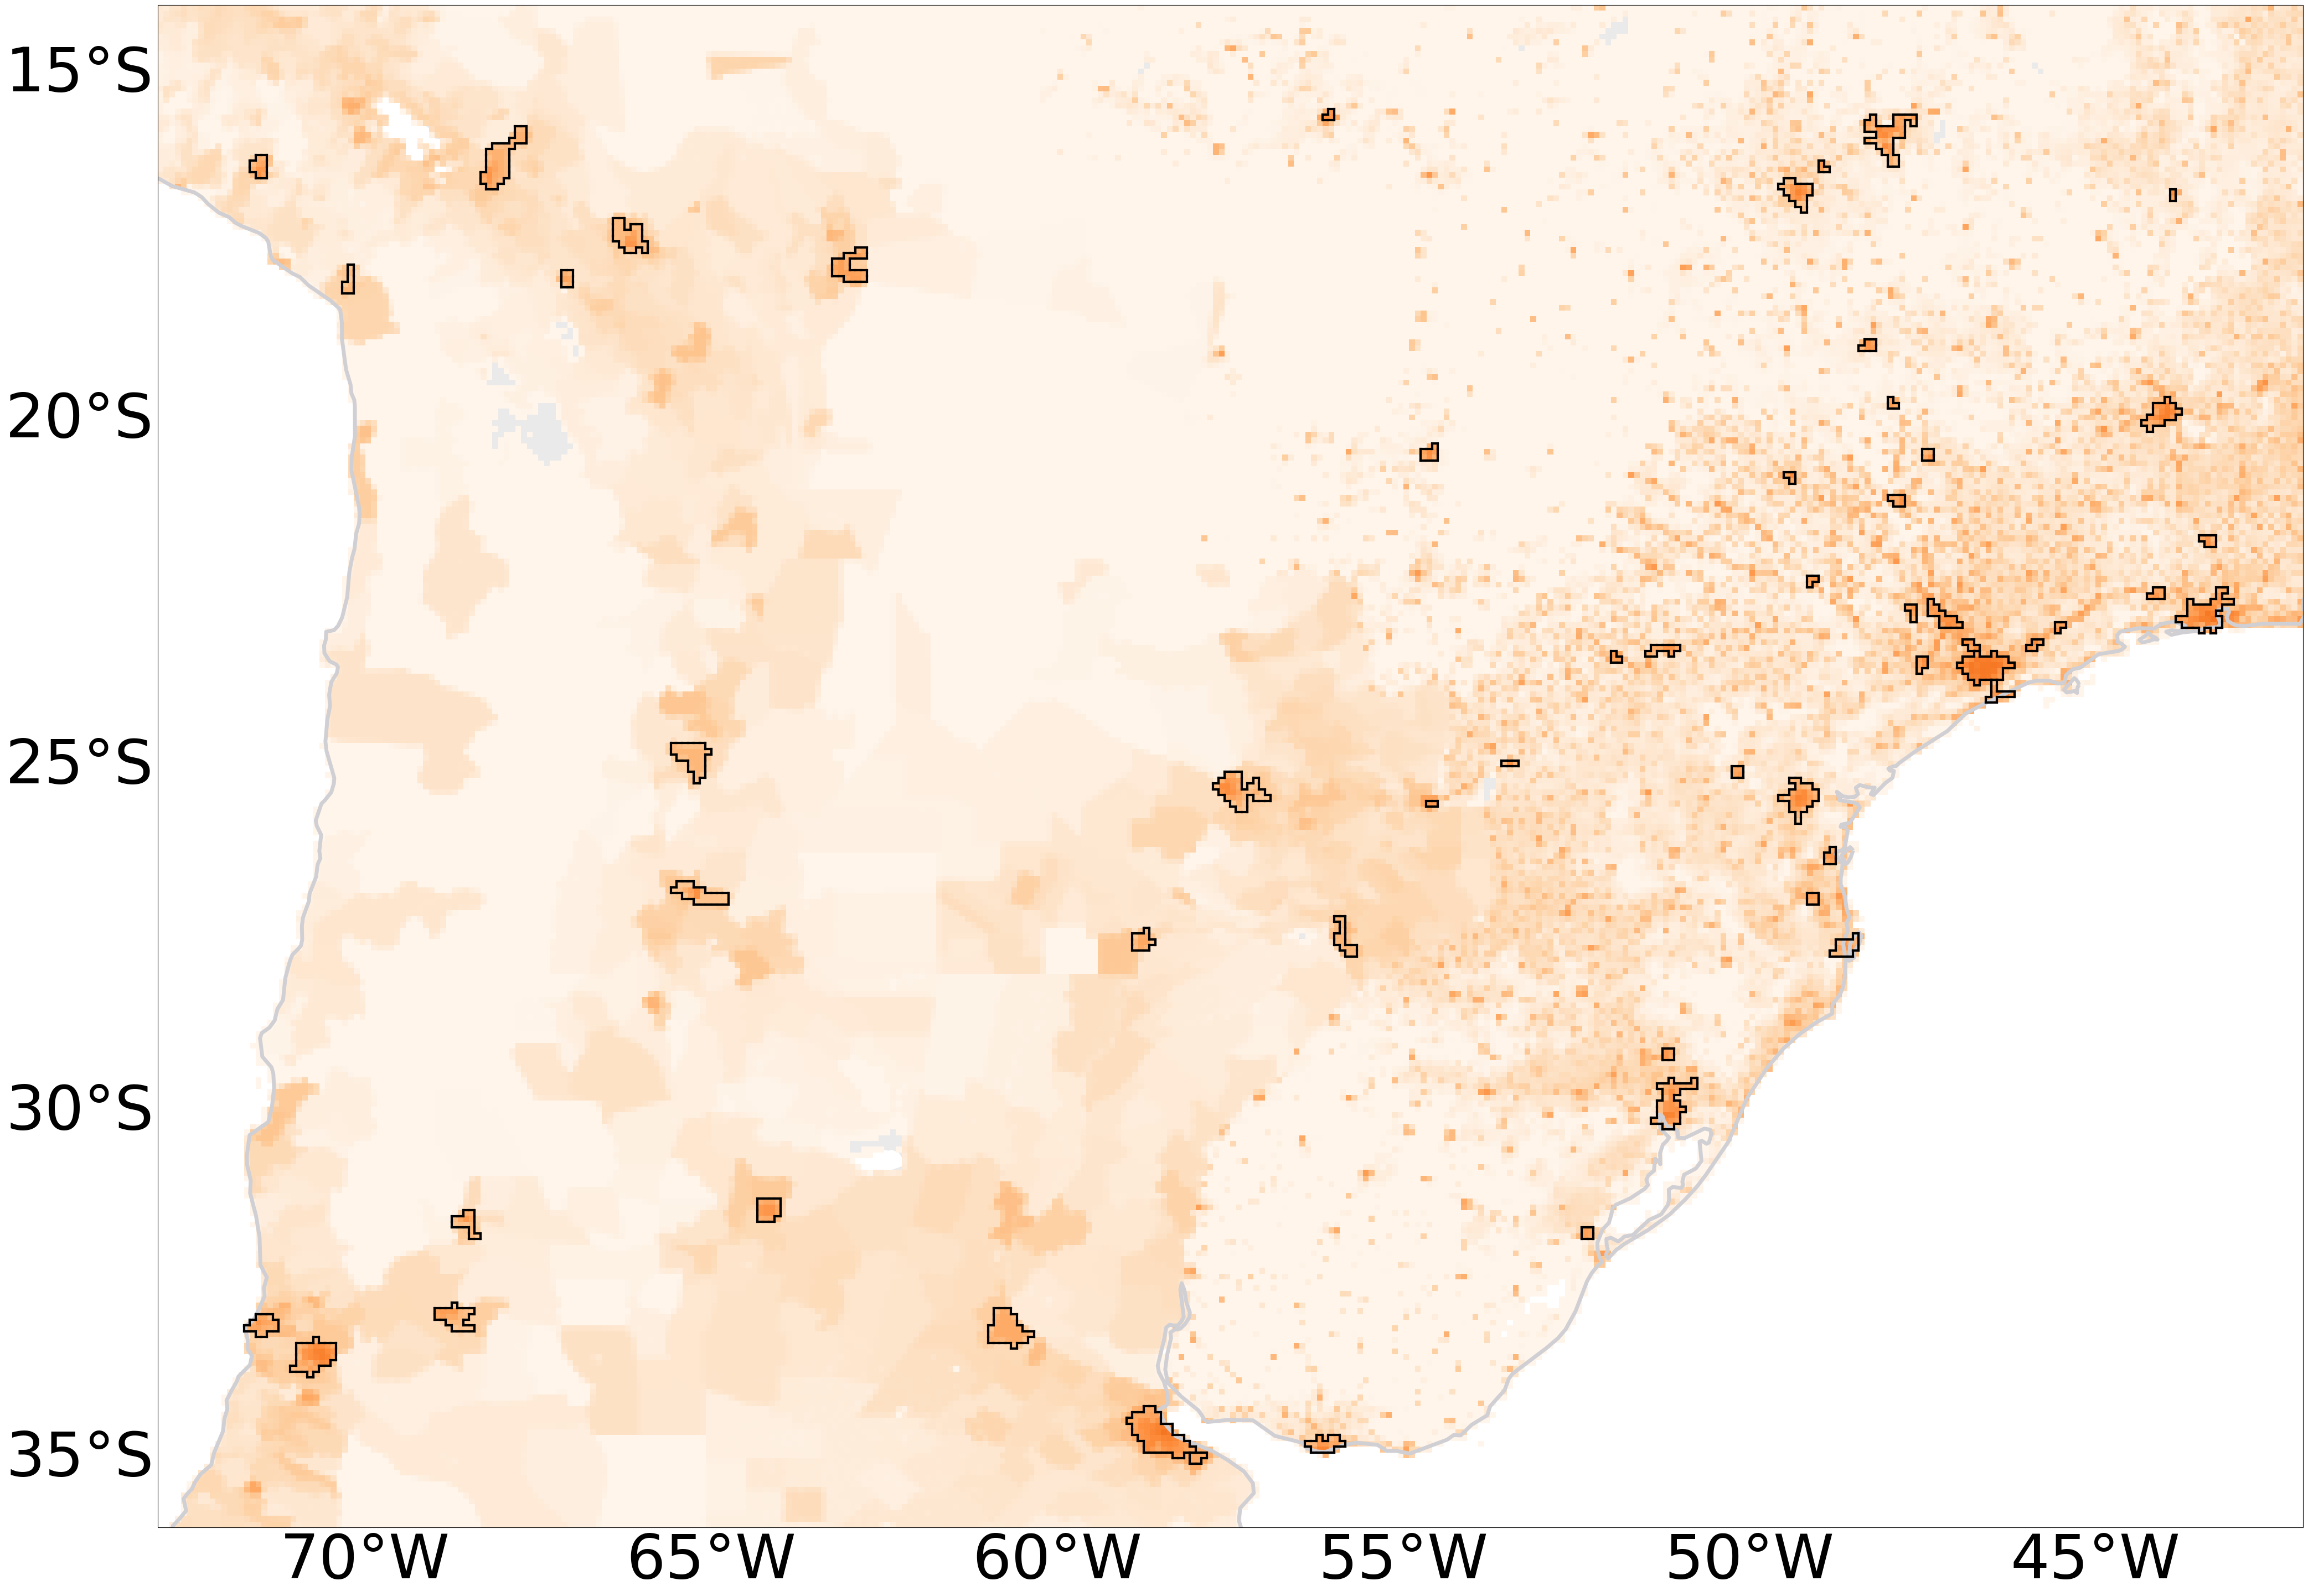

In [4]:
left, right, bottom, top = -73, -42, -36, -14
region_plot(left, right, bottom, top, dotwidth=3, linewidth=3, vmax=1e9, fontsize=80)

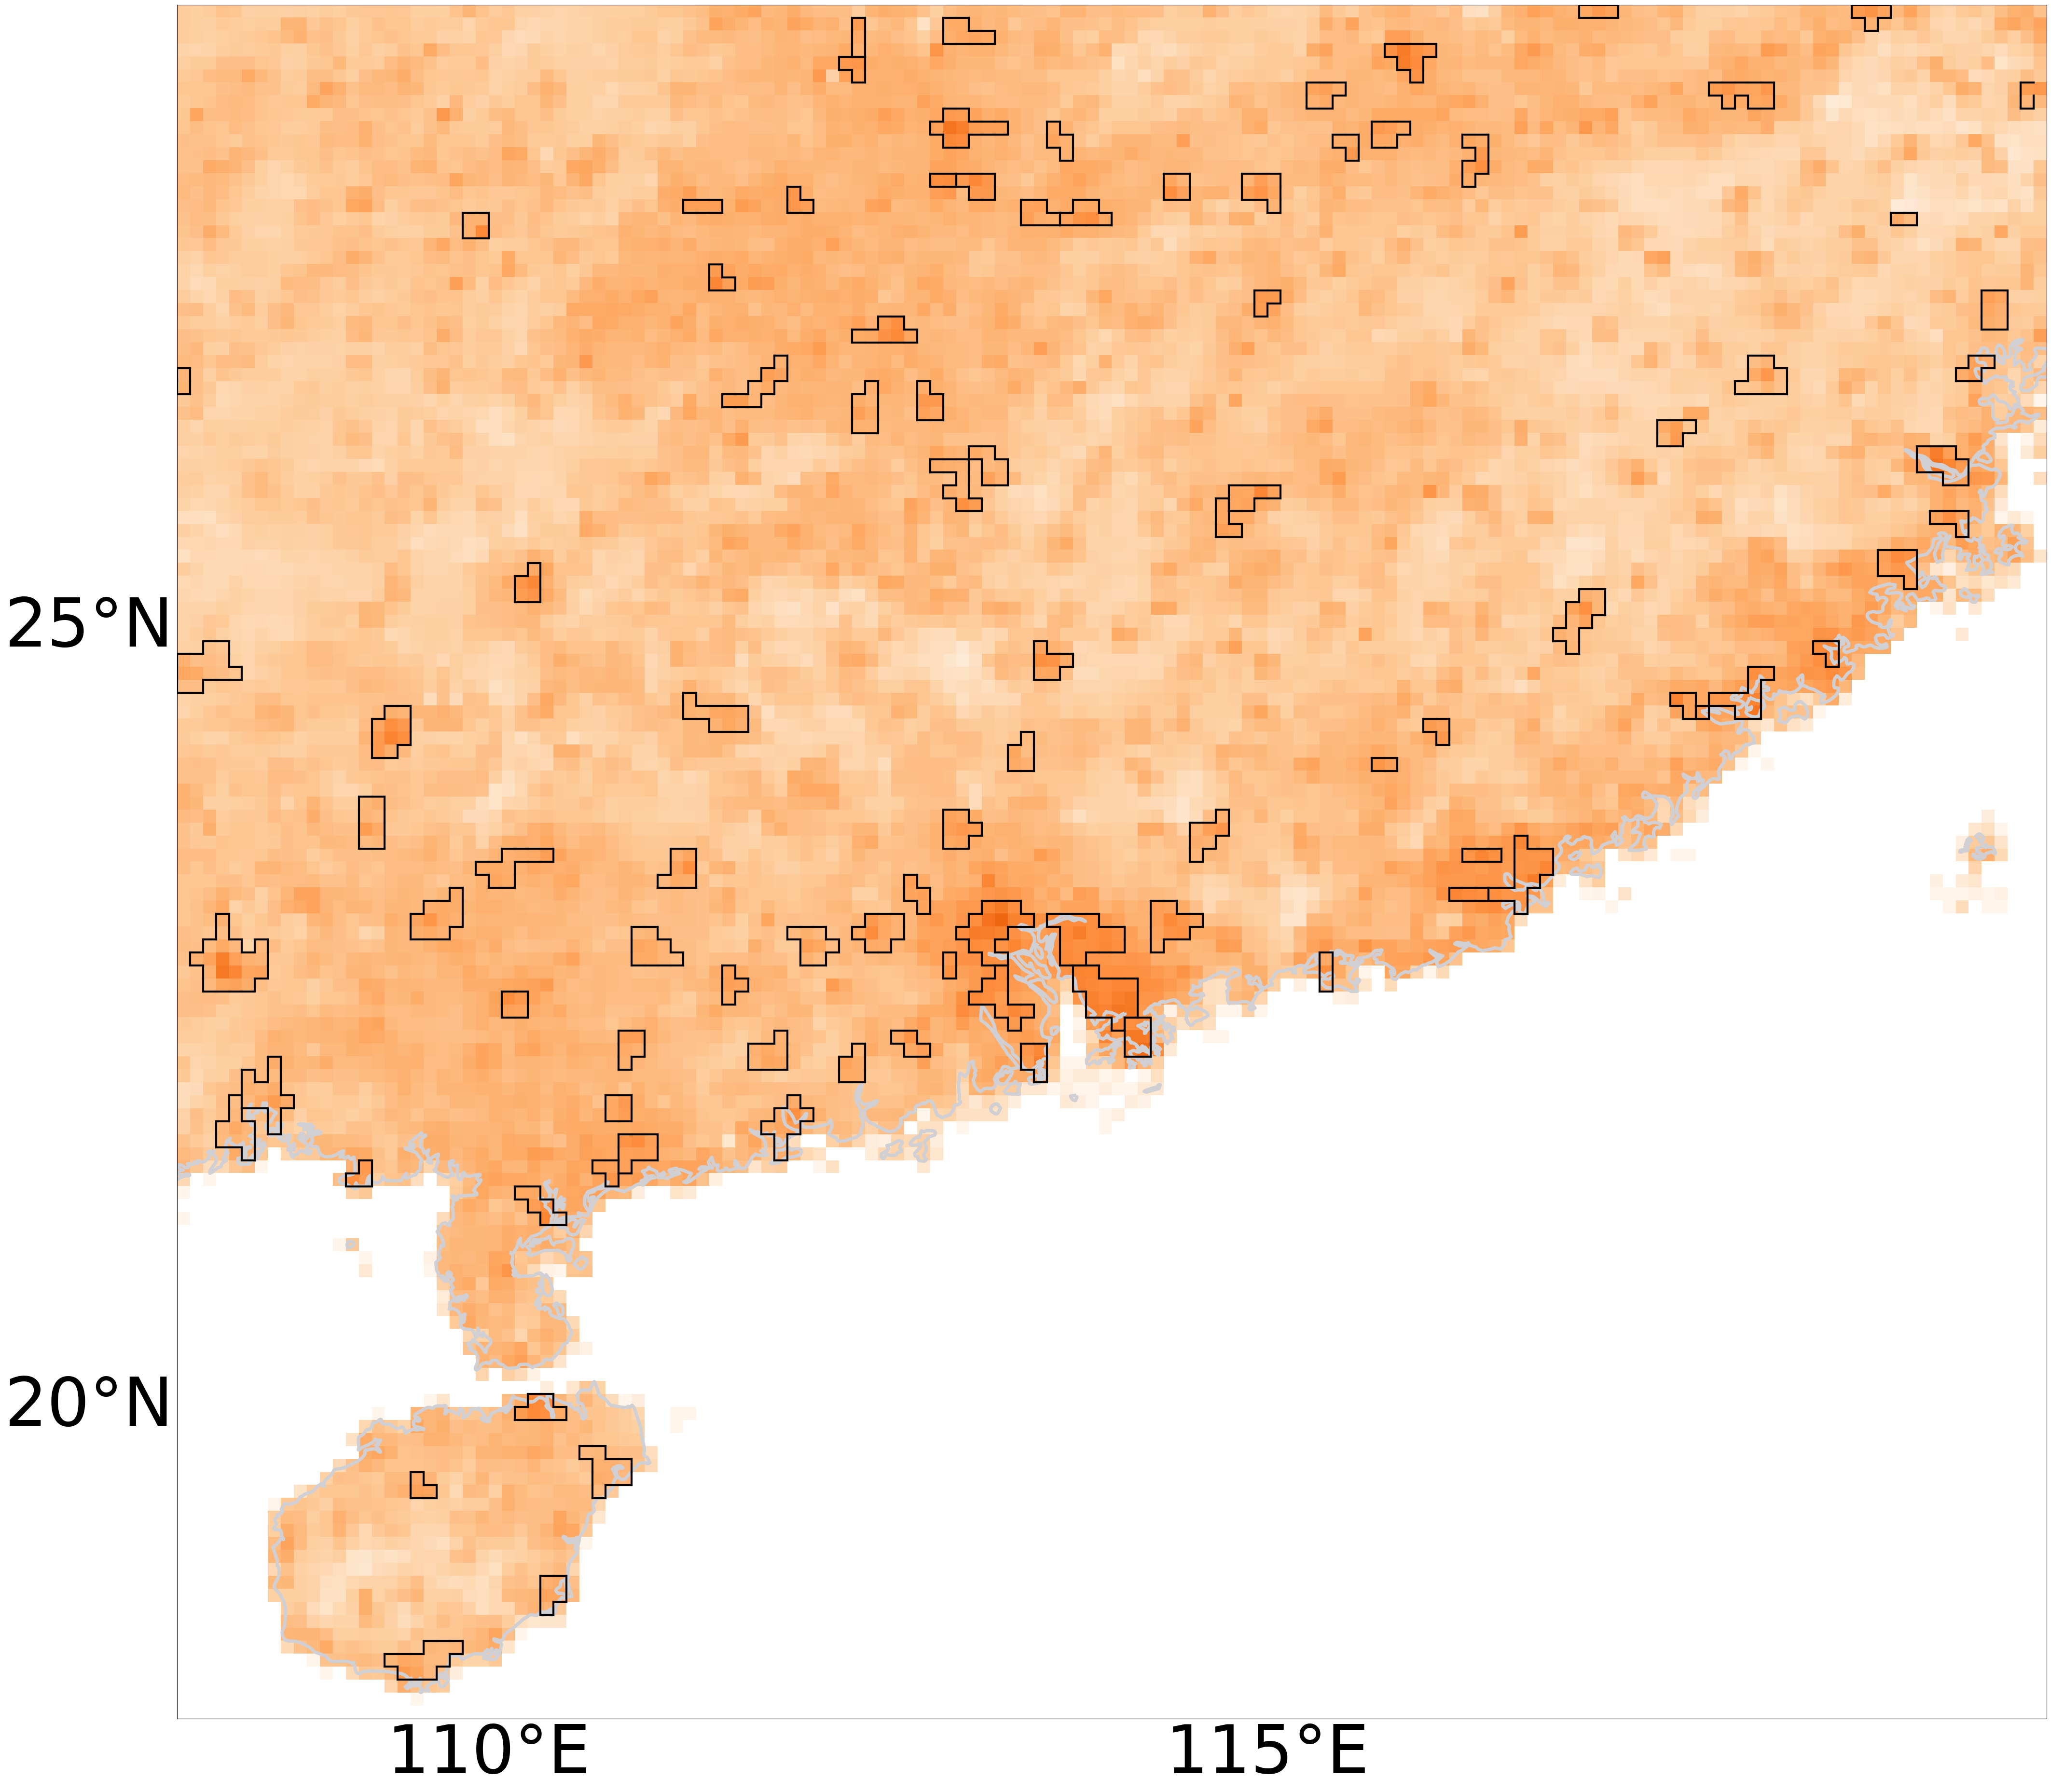

In [5]:
left, right, bottom, top = 108, 120, 18, 29
region_plot(left, right, bottom, top, dotwidth=6, linewidth=3, vmax=1e9, fontsize=100)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


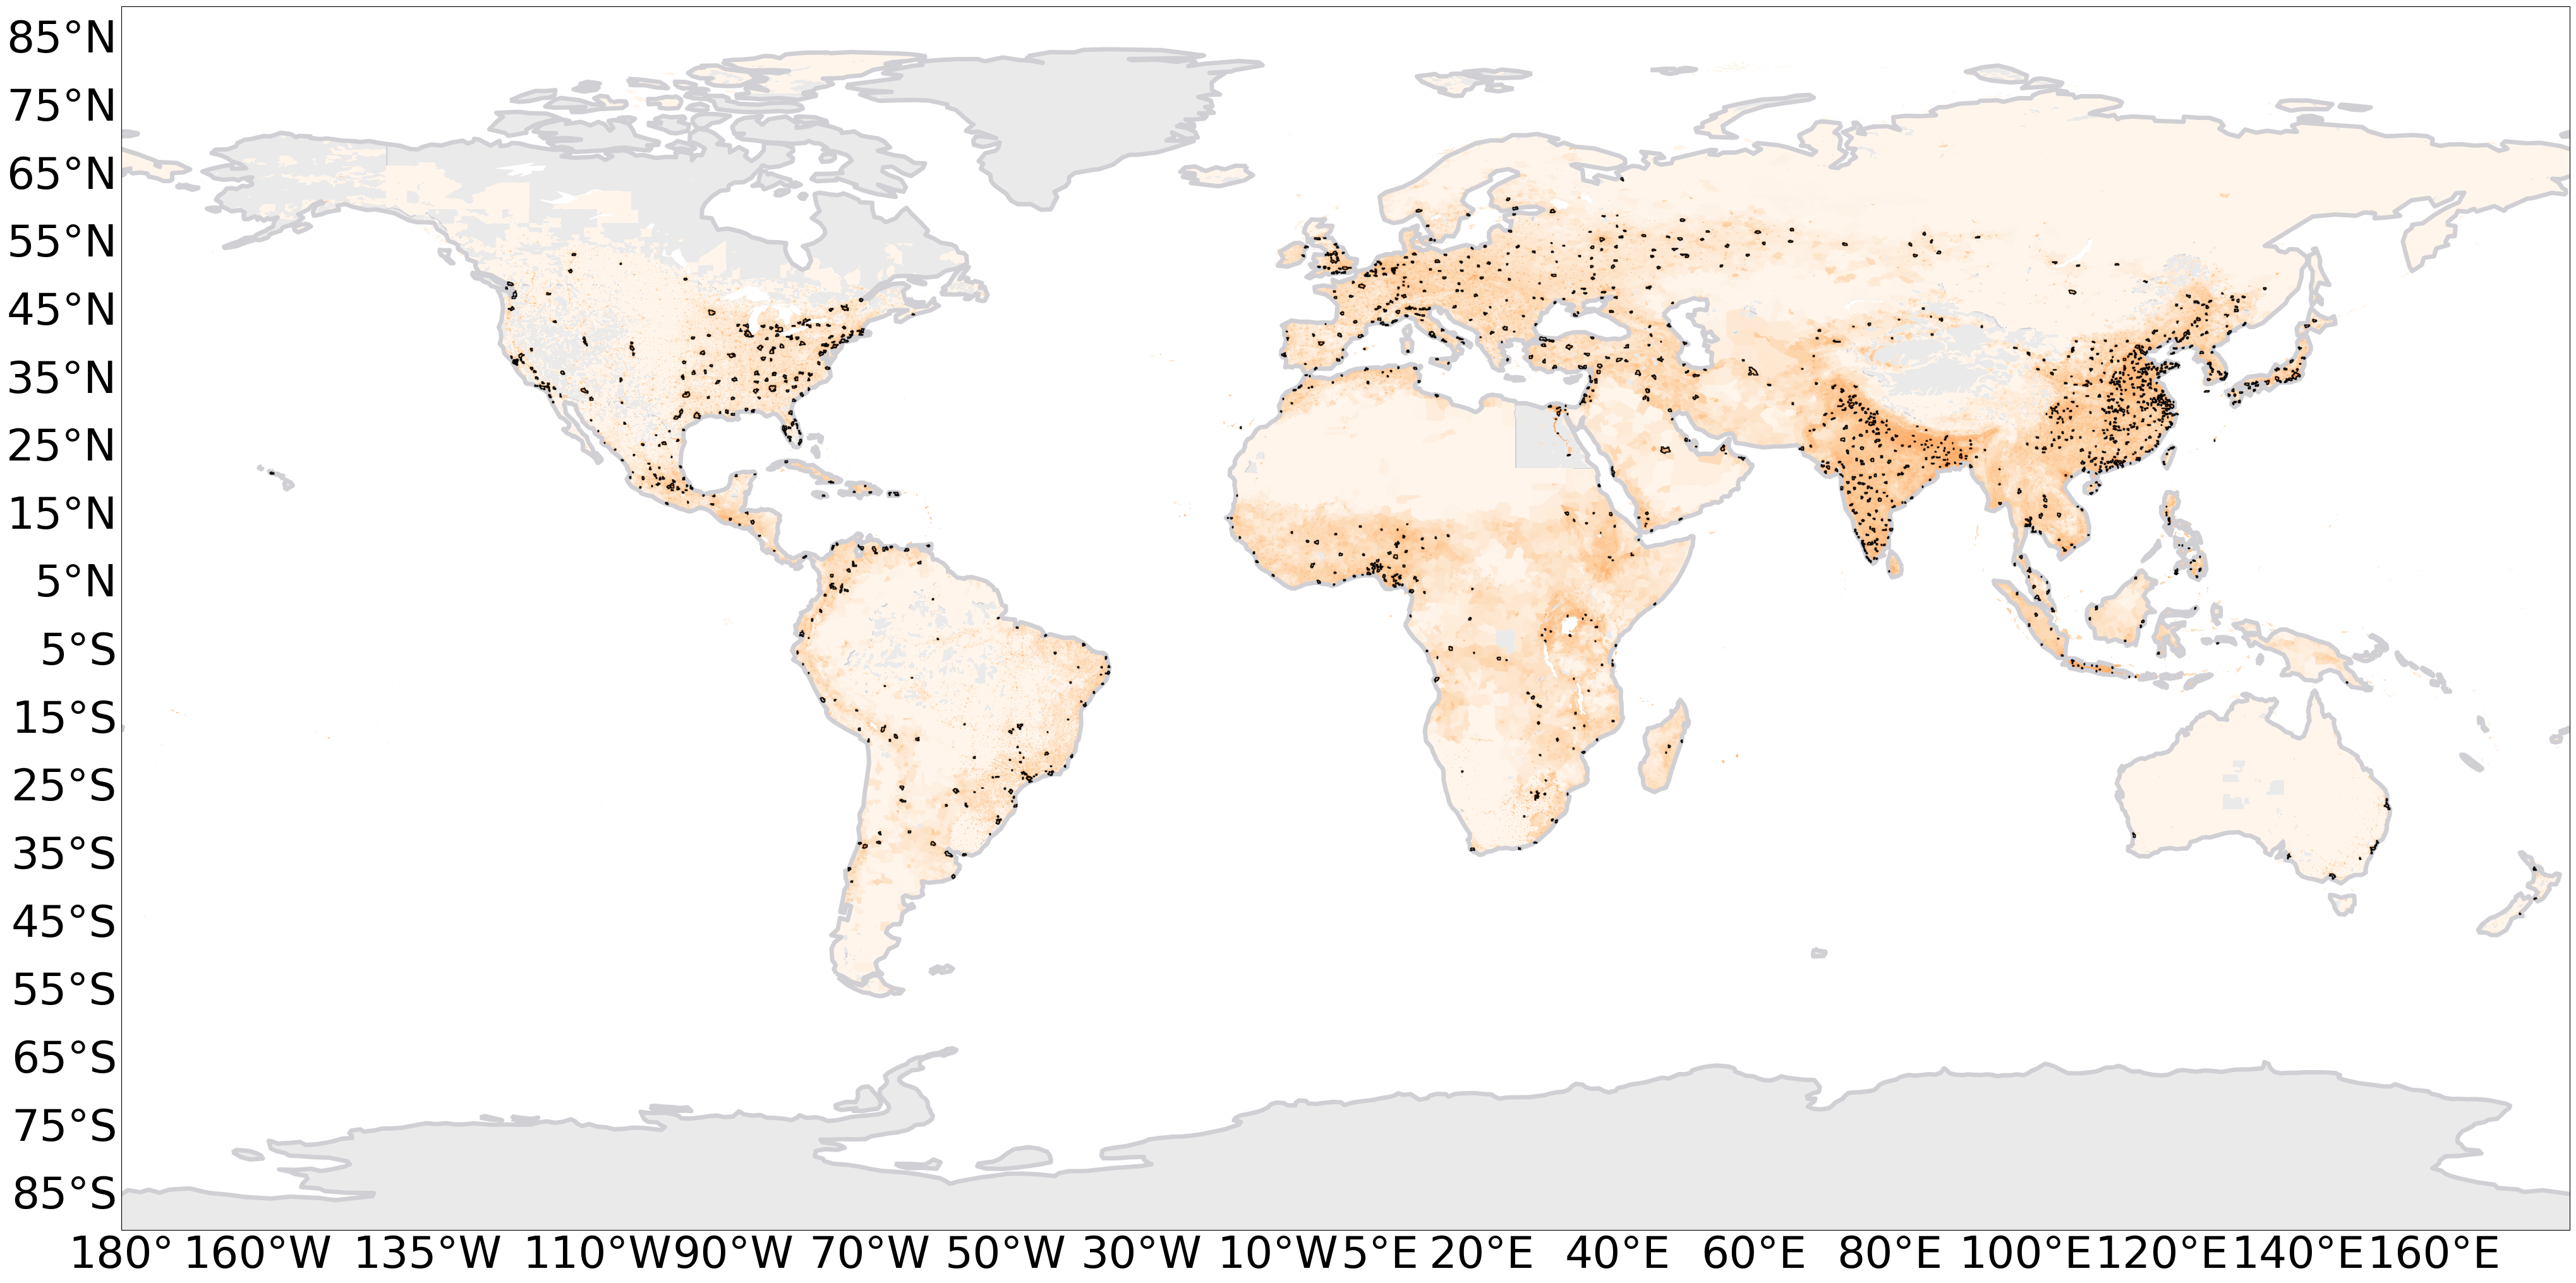

In [18]:
left, right, bottom, top = -180, 180, -90, 90
region_plot(left, right, bottom, top, dotwidth=1, linewidth=1, vmax=1e10, fontsize=50)